
# Movie Recommendation System
## Group 6 Phase 4 Project
### Contributors
 1. [Dennis Mwanzia](https://github.com/DennisMwanzia)
 2. [Amos Kipkirui](https://github.com/Amoskipkirui)
 3. [Robert Mbau](https://github.com/robertmbau)
 4. [Fiona Kungu](https://github.com/Fiona-Kungu)
 5. [Maureen Kitanga](https://github.com/ndungek)
 6. [Edwin Muhia](https://github.com/rurungamuhia)
 

## Overview
- MovieXplosion, a new streaming platform wants to improve their user satisfaction. The performance of the platform is dependent on how they can keep user engaged, one way to do this is by providing tailor-made recommendations to the users to drive them to spend more time on the platform.
- The project aims to develop a system that suggests movies to users. We will implement this using collaborative filtering, content-based filtering and hybrid approaches.
## Problem Statement
- The current system that the platform employs does not provide suitable recommendations to users which has led to low user engagement, satisfaction and retention. The system also has no way of providing new users with good recommendations and the existing users do not receive tailor-made recommendations.
- The new system aims to bypass these issues and provide relevant recommendations to all users.
## Objectives
1. Build a model that provides top 5 recommendations to a user.
2. Develop a system that will address the `cold start` problem for new users.
3. Enhance the recommendation system to provide accurate and relevant movie suggestions based on the user.
4. Evaluate the system performance using appropriate metrics such as `RMSE`.
## Data Understanding
The data used was sourced from [MovieLens](https://grouplens.org/datasets/movielens/latest/), we used the small dataset due to limited computational power. The data contains information about movies, ratings by users and other relevant information.
### Data Description
There are several files available with different columns:
1. Movies File
- It contains information about the movies.<br>
`movieId` - Unique identifier for each movie.<br>
`title` - The movie titles.<br>
`genre` - The various genres a movie falls into.<br>
2. Ratings file
- It contains the ratings for the movies by different users.<br>
`userId` - Unique identifier for each user<br>
`movieId` - Unique identifier for each movie.<br>
`rating` - A value between 0 to 5 that a user rates a movie on. A higher rating indicates a higher preference.<br>
`timestamp` - This are the seconds that have passed since Midnight January 1, 1970(UTC)
3. Tags file
- It has user-generated words or short phrases about a movie with the meaning or value being determined ny the specific user.<br>
`userId` - Unique identifier for each user<br>
`movieId` - Unique identifier for each movie.<br>
`tag` - A word or phrase determined by the user.<br>
`timestamp` - This are the seconds that have passed since Midnight January 1, 1970(UTC)
4. Links file
- This are identifiers that can be used to link to other sources of movie data as provide by MovieLens.<br>
`movieId` -  It's an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.<br>
`imdbId` -  It's an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.<br>
`tmdbId` -  is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862. <br>

In [3]:
#importing relevant libraries
#standard libraries
import pandas as pd
import numpy as np


#visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline


from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline,KNNWithMeans
from surprise.model_selection import GridSearchCV


In [4]:
# load data
mov_df = pd.read_csv('Data/movies.csv')
mov_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# ratings dataframe
ratings_df = pd.read_csv('Data/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# ratings dataframe
links_df = pd.read_csv('Data/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
# ratings dataframe
tags_df = pd.read_csv('Data/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [8]:
# We have userID and timestamp columns in the tags data. Therefore, we dropped the two columns before we merged the entire dataset

# Drop the 'userId' and 'timestamp' columns from the 'merged_dataset'
tags_df = tags_df.drop(['userId', 'timestamp'], axis=1)

# View the updated DataFrame
tags_df.head()


,movieId,tag
0,60756,funny
1,60756,Highly quotable
2,60756,will ferrell
3,89774,Boxing story
4,89774,MMA


In [9]:
#Data Exploration

In [10]:
# Checking Missing Data & Null Values
# check for missing values in mov_df
mov_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
# check for missing values in ratings_df
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
# check for missing values in links_df
links_df.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [13]:
# check for missing values in tags_df
tags_df.isna().sum()

movieId    0
tag        0
dtype: int64

In [14]:
# We have 8 missing values for tmdbID in Links CSV therefore, we went ahead to investigate them

# Count the number of missing values in the 'tmdbId' column
missing_values = links_df['tmdbId'].isnull().sum()

# Get the rows with missing values in the 'tmdbId' column
missing_rows = links_df[links_df['tmdbId'].isnull()]

# Print the number of missing values and the rows containing them
print("Number of missing values in 'tmdbId' column:", missing_values)
print("Rows with missing values in 'tmdbId' column:")
print(missing_rows)


Number of missing values in 'tmdbId' column: 8
Rows with missing values in 'tmdbId' column:
      movieId  imdbId  tmdbId
624       791  113610     NaN
843      1107  102336     NaN
2141     2851   81454     NaN
3027     4051   56600     NaN
5532    26587   92337     NaN
5854    32600  377059     NaN
6059    40697  105946     NaN
7382    79299  874957     NaN


In [15]:
# Combining the four datasets

# Merge the 'movies' and 'ratings' datasets based on the 'movieId' column
movies_and_ratings = pd.merge(left=mov_df, right=ratings_df, on='movieId')

# Merge the 'movies_and_ratings' and 'links' datasets based on the 'movieId' column
movies_ratings_links = pd.merge(left=movies_and_ratings, right=links_df, on='movieId')

# Merge the 'movies_ratings_links' and 'tags' datasets based on the 'movieId' column
merged_dataset = pd.merge(left=movies_ratings_links, right=tags_df, on='movieId')

# Print the merged dataset
merged_dataset.head()


,movieId,title,genres,userId,rating,timestamp,imdbId,tmdbId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,fun
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar


In [16]:
merged_dataset.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'imdbId',
       'tmdbId', 'tag'],
      dtype='object')

In [17]:
# Feature Engineering the Title column to extract the Year in which a movie was released

# Extract the year from the 'Title' column and create a new column 'Year'
merged_dataset['Year'] = merged_dataset['title'].str.extract(r'\((\d{4})\)')

# View the updated DataFrame with the 'Year' column
merged_dataset.head()


,movieId,title,genres,userId,rating,timestamp,imdbId,tmdbId,tag,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,fun,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar,1995


In [18]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 233212
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    233213 non-null  int64  
 1   title      233213 non-null  object 
 2   genres     233213 non-null  object 
 3   userId     233213 non-null  int64  
 4   rating     233213 non-null  float64
 5   timestamp  233213 non-null  int64  
 6   imdbId     233213 non-null  int64  
 7   tmdbId     233213 non-null  float64
 8   tag        233213 non-null  object 
 9   Year       233210 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 19.6+ MB


In [19]:
# Drop the year in parenthesis from the title column

# Remove the year in parenthesis from the 'Title' column
merged_dataset['title'] = merged_dataset['title'].str.replace(r'\s*\(\d{4}\)', '')

# View the updated DataFrame
merged_dataset.head()


,movieId,title,genres,userId,rating,timestamp,imdbId,tmdbId,tag,Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,pixar,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,fun,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,pixar,1995


In [20]:
# Count the number of NaN values in the 'Year' column
num_nan_values = merged_dataset['Year'].isna().sum()
print("Number of NaN values in the 'Year' column:", num_nan_values)

Number of NaN values in the 'Year' column: 3


In [21]:
# Replace NaN values with a default value
default_year = 0  # 
merged_dataset['Year'] = merged_dataset['Year'].fillna(default_year).astype(int)


## Exploratory Data Analysis

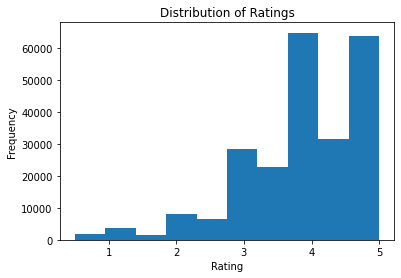

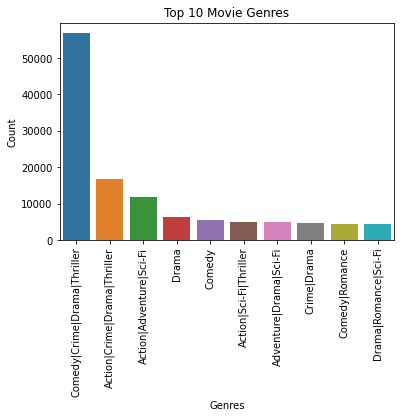

In [22]:
# Distribution of ratings
plt.hist(merged_dataset['rating'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

# Bar chart for genres
genres_counts = merged_dataset['genres'].value_counts().head(10)
sns.barplot(x=genres_counts.index, y=genres_counts.values)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Top 10 Movie Genres')
plt.xticks(rotation=90)
plt.show()

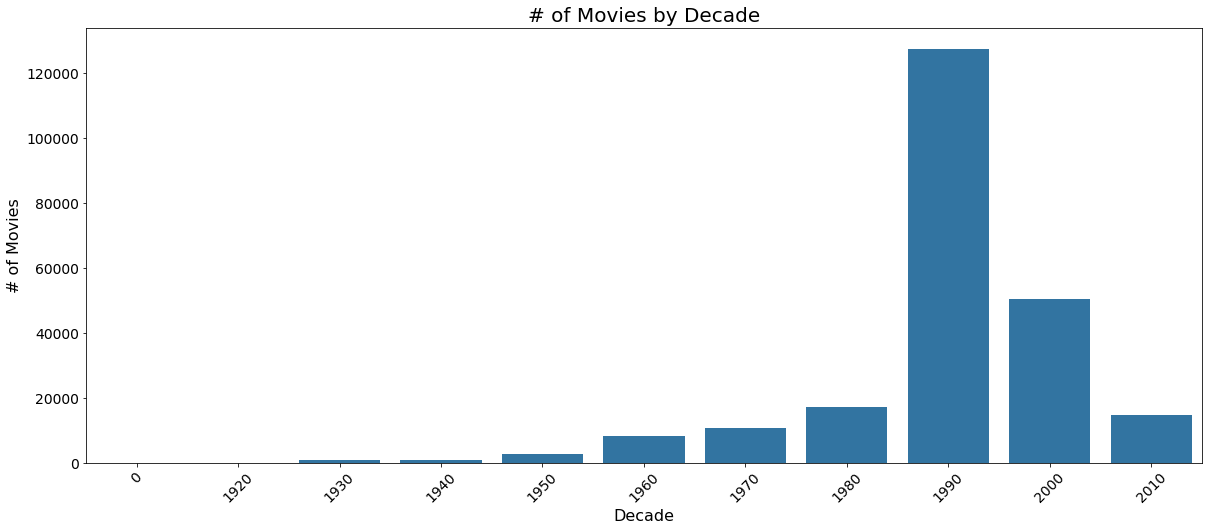

In [23]:
# Group years by decades
merged_dataset['Decade'] = (merged_dataset['Year'] // 10) * 10

fig, ax = plt.subplots(figsize=(20, 8))

sns.countplot(x='Decade',
              data=merged_dataset,
              color='tab:blue')

plt.xlabel("Decade", fontsize=16)
plt.ylabel("# of Movies", fontsize=16)
plt.title("# of Movies by Decade", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
ax.grid(False)

# Update x-axis labels with the decade range
decades = np.sort(merged_dataset['Decade'].dropna().unique())
plt.xticks(np.arange(len(decades)), decades)

plt.show()


Movie production increase steadily from 1920s and reached its peak in the 1990s before declining in the new millenium to the same levels as 1980s.

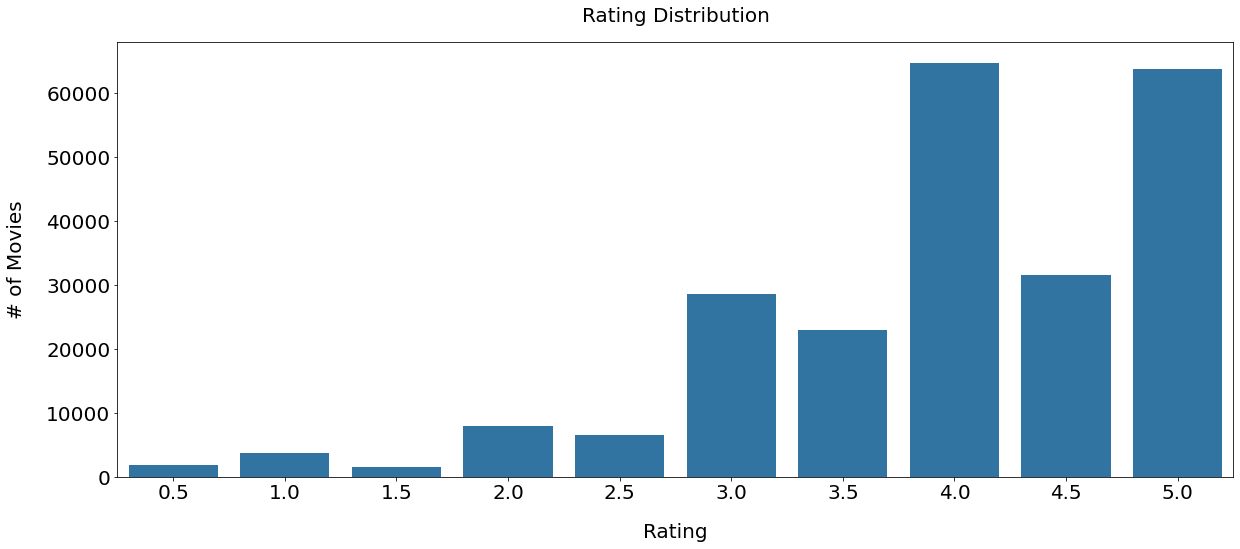

In [24]:
fig, ax = plt.subplots(figsize=(20, 8))

rating_counts = merged_dataset['rating'].value_counts().sort_index()

sns.barplot(x=rating_counts.index,
            y=rating_counts.values,
            color='tab:blue')

plt.title("Rating Distribution", fontsize=20, pad=20)
plt.xlabel("Rating", fontsize=20, labelpad=20)
plt.ylabel("# of Movies", fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(False)

plt.show()


The highest rated movies got `5` while the lowest rated was `0.5`.<br>
Most movies were rated at `5` and `4` with a few getting ratings of `0.5` and `1.5`.

In [44]:
from wordcloud import WordCloud
# Create the word cloud and word frequency
genres_text = '|'.join(merged_dataset['genres'])
genres_list = genres_text.split('|')
word_frequency = {}
for genre in genres_list:
    word_frequency[genre] = word_frequency.get(genre, 0) + 1

# Create the word cloud
wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_frequency)

# Create the bar plot
word_frequency_2 = pd.Series(word_frequency)
word_frequency_2 = word_frequency_2.sort_values(ascending=False)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the word cloud
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set_title('GENRES')
ax1.axis('off')

# Plot the bar plot
sns.barplot(x=word_frequency_2.index, y=word_frequency_2.values, ax=ax2)
ax2.set_xlabel('Genre')
ax2.set_ylabel('Count')
ax2.set_title('Genres')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()

AttributeError: 'TransposedFont' object has no attribute 'getbbox'

The genres `Drama`, `Thriller`, `Crime` and `Comedy` are the most popular. They are the most appearing genres in the movies.<br>
`Film Noir` and `Documentary` are the least watched genres.

## Descriptive statistics

In [ ]:
# Summary statistics for ratings
rating_stats = merged_dataset['rating'].describe()
print(rating_stats)

# Percentiles for ratings
percentiles = [0.25, 0.50, 0.75]
rating_percentiles = merged_dataset['rating'].quantile(percentiles)
print(rating_percentiles)


count    233213.000000
mean          3.966535
std           0.968637
min           0.500000
25%           3.500000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64
0.25    3.5
0.50    4.0
0.75    5.0
Name: rating, dtype: float64


The mean movie rating is `3.97` with a standard deviation of `0.97`.<br>
Atleast 50% of the movies were rated `4.0`. This implies that most of the movies produced are liked by the consumers.
Therefore, our streaming platform should aim to feature movies rated atleast `3.5` and above.

In [ ]:
# Genre Analysis
# Count of movies per genre
genre_counts = merged_dataset['genres'].str.split('|', expand=True).stack().value_counts()
print(genre_counts)

print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')

# Relationship between genres and ratings
genre_ratings = merged_dataset.groupby('genres')['rating'].mean()
genre_ratings = genre_ratings.sort_values(ascending=False)

print(genre_ratings)



Drama                 148389
Thriller              116891
Crime                 103102
Comedy                 96901
Action                 69549
Sci-Fi                 51977
Adventure              47939
Romance                25344
Mystery                24352
Fantasy                16220
IMAX                   12263
War                    11737
Children               11595
Animation              10466
Horror                 10199
Musical                 4496
Western                 2354
Film-Noir                783
Documentary              711
(no genres listed)         3
dtype: int64
+++++++++++++++++++++++++++++++++++++++++++++++++++++
genres
Adventure|Comedy|Fantasy|Musical            5.000000
Animation|Drama|Sci-Fi|IMAX                 5.000000
Drama|Horror|Mystery|Sci-Fi|Thriller        4.750000
Action|Adventure|Animation|Crime|Fantasy    4.625000
(no genres listed)                          4.500000
                                              ...   
Romance                     

The genre combinations of `Adventure ,Comedy, Fantasy, Musical` and `Animation,Drama,Sci-Fi,IMAX` got the highest rating of 5 while `Action,Adventure,Children,Drama` got the lowest rating 1.75.

In [ ]:
#User Analysis
# Distribution of ratings by user
user_ratings = merged_dataset.groupby('userId')['rating'].count()
print(user_ratings)

# Top 10 most active users
top_users = user_ratings.nlargest(10)
print(top_users)


userId
1       593
2       143
3        27
4       580
5       278
       ... 
606    1407
607     450
608    1285
609     241
610    1701
Name: rating, Length: 610, dtype: int64
userId
474    2455
414    2343
599    2100
68     1791
610    1701
274    1665
249    1635
448    1575
380    1536
305    1460
Name: rating, dtype: int64


In [ ]:
ratings_by_decade

In [ ]:
#Temporal Analysis
# Trends in ratings over time
ratings_over_time = merged_dataset.groupby('Year')['rating'].mean().reset_index()
ratings_over_time['Decade'] = (ratings_over_time['Year'] // 10) * 10

ratings_by_decade = ratings_over_time.groupby('Decade')['rating'].mean().reset_index()
ratings_by_decade['Decade'] = pd.to_numeric(ratings_by_decade['Decade']

print(ratings_by_decade)




# Line plot for ratings over time
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(ratings_by_decade['Decade'], ratings_by_decade['rating'])
plt.xlabel('Decade')
plt.xlim(1920, 2000)  # Set the x-axis limits
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')

# Show the plot
plt.show()

SyntaxError: invalid syntax (<ipython-input-78-7152569ae353>, line 9)

The lowest average rating was recorded for movies produced produced in 1930s while movies produced in 1940s got the highest average rating.<br>
Generally, average ratings have been declining since 1950s with a very sharp decline observed between 1970 and 1980.<r>
The year of movie production will be very useful to determine the average rating of a movie.

## Modeling

In [ ]:
# Load ratings dataset
df = pd.read_csv('Data/ratings.csv')
new_df = df.drop(columns='timestamp')

# Load movies dataset
df_movies = pd.read_csv('Data/movies.csv')

# Create Surprise dataset
reader = Reader()
data = Dataset.load_from_df(new_df, reader)
dataset = data.build_full_trainset()

In [ ]:
from surprise.model_selection import cross_validate

def evaluate_models(data):
    # Split the data into training and test sets
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    # Define a list of models to evaluate
    models = [
        SVD(),
        KNNBasic(sim_options={'name': 'pearson', 'user_based': True}),
        KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
    ]

    # Evaluate each model and store the results
    results = []
    for model in models:
        # Perform cross-validation
        cv_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=False)

        # Get the average RMSE from cross-validation
        rmse = cv_results['test_rmse'].mean()

        # Store the model and its performance
        results.append({'model': model.__class__.__name__, 'rmse': rmse})

    # Sort the results based on the RMSE in ascending order
    sorted_results = sorted(results, key=lambda x: x['rmse'])

    # Print the results
    for result in sorted_results:
        print(f"Model: {result['model']}, RMSE: {result['rmse']}")

    # Select the best performing model
    best_model = sorted_results[0]['model']
    print(f"Best performing model: {best_model}")

evaluate_models(data)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Model: SVD, RMSE: 0.873009518648073
Model: KNNWithMeans, RMSE: 0.8967864860489702
Model: KNNBasic, RMSE: 0.9721778656987148
Best performing model: SVD


In [ ]:
# Perform grid search for SVD
params = {'n_factors': [20, 50, 100], 'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8689121690786351, 'mae': 0.6680655705098882}
{'rmse': {'n_factors': 50, 'reg_all': 0.05}, 'mae': {'n_factors': 50, 'reg_all': 0.05}}


In [ ]:
# Train SVD model
svd = SVD(n_factors=50, reg_all=0.05)
svd.fit(dataset)


In [ ]:
# Function to get user ratings for movies
def movie_rater(movie_df, num, genre=None):
    userID = 1000  # Set a default userID for new users
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen, or type "escape" to see personalized recommendations:\n')
        if rating == 'n':
            continue
        elif rating.lower() == 'escape':
            return None  # Indicates the user wants personalized recommendations
        else:
            rating_one_movie = {'userId': userID, 'movieId': movie['movieId'].values[0], 'rating': float(rating)}
            rating_list.append(rating_one_movie)
            num -= 1
    return rating_list

      movieId                                              title  \
5304     8796  Funny Thing Happened on the Way to the Forum, ...   

              genres  
5304  Comedy|Musical  
How do you rate this movie on a scale of 1-5, press n if you have not seen:
5
      movieId                 title  genres
5753    31000  Sweet Liberty (1986)  Comedy
How do you rate this movie on a scale of 1-5, press n if you have not seen:
5
      movieId                        title        genres
2491     3325  Next Best Thing, The (2000)  Comedy|Drama
How do you rate this movie on a scale of 1-5, press n if you have not seen:
3
      movieId                       title          genres
3251     4394  Beach Blanket Bingo (1965)  Comedy|Musical
How do you rate this movie on a scale of 1-5, press n if you have not seen:
1


In [ ]:
# Function to recommend popular movies
def recommend_popular_movies(ratings_df, movies_df, genre, num_recommendations=5):
    # Calculate average ratings and number of ratings for each movie
    average_ratings = ratings_df.groupby('movieId')['rating'].mean()
    num_ratings = ratings_df.groupby('movieId')['rating'].count()

    # Create a DataFrame with movie popularity metrics
    popularity_df = pd.DataFrame({'average_rating': average_ratings, 'num_ratings': num_ratings})

    # Sort movies based on popularity metrics (e.g., average rating and number of ratings)
    popularity_df = popularity_df.sort_values(by=['average_rating', 'num_ratings'], ascending=False)

    # Filter movies by genre (if provided)
    if genre:
        popular_movies = movies_df[movies_df['genres'].str.contains(genre)]
        popular_movies = popular_movies.merge(popularity_df, on='movieId', how='left')
    else:
        popular_movies = popularity_df.merge(movies_df, on='movieId', how='left')

    # Get the top-rated or most popular movies from the sorted DataFrame
    top_movies = popular_movies.head(num_recommendations)

    # Return the recommended movies
    return top_movies['title']

In [ ]:
# Load ratings and movies data
ratings_df = pd.read_csv('Data/ratings.csv')
movies_df = pd.read_csv('Data/movies.csv')

In [ ]:
# Prompt the user to enter their user ID
user_id = input('Enter your user ID: ')

# Convert user_id to int data type
user_id = int(user_id)

[(318, 4.376130388378028),
 (750, 4.350073233537948),
 (1204, 4.333187008039224),
 (858, 4.28256969999299),
 (904, 4.281691007925962)]

In [ ]:
# Check if the user already exists in the ratings dataset
if user_id in ratings_df['userId'].unique():
    # Get user ratings using the movie_rater function
    user_rating = movie_rater(movies_df, 4, genre='Comedy')

    if user_rating is None:
        # User wants personalized recommendations
        print("Personalized recommendations based on user's ratings")
        
        # Extract the user's ratings from the ratings dataframe
        user_ratings = ratings_df[ratings_df['userId'] == user_id]

        # Group the ratings by movie and calculate the average rating for each movie
        movie_ratings = user_ratings.groupby('movieId')['rating'].mean().reset_index()

        # Merge movie ratings with movie metadata
        personalized_movies = movie_ratings.merge(movies_df, on='movieId', how='left')

        # Sort the movies based on the average rating
        personalized_movies = personalized_movies.sort_values(by='rating', ascending=False)

        # Get the top 5 movie recommendations
        recommendations = personalized_movies['title'].head(5)

        # Print the recommendations
        for idx, rec in enumerate(recommendations):
            print(f"Recommendation #{idx+1}: {rec}")

    else:
        # User has provided ratings
        # Add the new ratings to the original ratings DataFrame
        user_ratings = pd.DataFrame(user_rating)
        new_ratings_df = pd.concat([ratings_df, user_ratings], ignore_index=True)

        # Define the reader
        reader = Reader(rating_scale=(1, 5))

        # Load the data from the DataFrame
        new_data = Dataset.load_from_df(new_ratings_df[['userId', 'movieId', 'rating']], reader)

        # Train the SVD model with the updated ratings
        svd = SVD()
        svd.fit(new_data.build_full_trainset())

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in movies_df['movieId'].unique():
            predicted_rating = svd.predict(user_id, movie_id).est
            predictions.append((movie_id, predicted_rating))

        # Sort the predicted ratings
        ranked_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

        # Print the top 5 movie recommendations for the user
        print("Top 5 movie recommendations based on your ratings:")
        for idx, rec in enumerate(ranked_predictions[:5]):
            title = movies_df.loc[movies_df['movieId'] == rec[0], 'title'].values[0]
            print(f"Recommendation #{idx+1}: {title}")

else:
    # New user without any ratings
    print("Popular movie recommendations:")
    genre = input("Enter a genre to get recommendations based on that (leave blank for all genres): ")
    recommendations = recommend_popular_movies(ratings_df, movies_df, genre, num_recommendations=5)
    for idx, rec in enumerate(recommendations):
        print(f"Recommendation #{idx+1}: {rec}")

ValueError: invalid literal for int() with base 10: 'M'